<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-analisis-tecnico/blob/main/ES_TA_Cap%C3%ADtulo_07_Optimizaci%C3%B3n_de_hiper_par%C3%A1metros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>

# Optimización de hiper parámetros
El objetivo es encontrar los parámetros óptimos de nuestra estrategia.

<br> 
### Contenido 
* Selección de parámetros con mapa de calor
* Selección de parámetros estadísticos
* Crear una función para automatizar el proceso

### Entorno

In [1]:
!pip install ta
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=c928c9dd37250ebce628511b0e79c013e41e3a374fa4b4c52bbe0919be758a3f
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 17.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

In [2]:
import pandas as pd
import ta
import yfinance as yf

import seaborn as sns

import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

### Funciones

In [31]:
def RSI(val, neutral, window):
  """ 
        ------------------------------------------------------------------------------
        | Output: La función da los rendimientos de la estrategia RSI                |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Valores de entrada de la acción      |
        |         -neutral (float): Valor neutral, es decir, zona de no acción       |
        |         -window (float): período de balanceo para el RSI                   |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("Necesitamos tener un nombre de columna Adj Close porque todos los cálculos se refieren a esta columna")
  
  val["rsi"] = ta.momentum.RSIIndicator(val["Adj Close"], window=window).rsi()


  
  """Señal de compra en largo """
  # Colocamos el umbral
  overbuy = 70
  neutral_buy = 50 + neutral

  # Poner valores nan para las columnas de la señal larga
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # Necesitamos definir la señal de apertura en largo (RSI ayer<55 y RSI hoy>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # Necesitamos definir la señal cierre en largo (RSI ayer>55 y RSI hoy<55) Señal falsa
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # Necesitamos definir la señal cierre en largo (RSI ayer<70 y RSI hoy>70) Señal de sobrecompra
  val.loc[(val["rsi"]>overbuy)&(val["yersteday_rsi"]<overbuy), "signal_long"] = 0



  """Señal de venta en corto """
  # Colocamos el umbral
  oversell = 30
  neutral_sell = 50 - neutral

  # Poner valores nan para las columnas de la señal larga
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # Necesitamos definir la señal de apertura en corto (RSI ayer>45 y RSI hoy<45)
  val.loc[(val["rsi"]<neutral_sell) & (val["yersteday_rsi"]>neutral_sell), "signal_short"] = -1

  # Necesitamos definir la señal de cierre en corto (RSI ayer<45 y RSI hoy>45) Señal falsa
  val.loc[(val["rsi"]>neutral_sell)&(val["yersteday_rsi"]<neutral_sell), "signal_short"] = 0

  # Necesitamos definir la señal de cierre en corto (RSI ayer>30 y RSI hoy<30) Señal de sobre venta
  val.loc[(val["rsi"]<oversell)&(val["yersteday_rsi"]>oversell), "signal_short"] = 0

  """Calcular el retorno """
  # Calculamos el porcentaje de variación del activo
  val["pct"] = val["Adj Close"].pct_change(1)

  # Calculamos las posiciones
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Calculamos el valor de retorno de la estrategia
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"]

In [5]:
def drawdown_function(serie):
  
  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1

  # We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown  = cum/running_max - 1 
  return drawdown

In [6]:
def BackTest(serie):

  # Import the benchmarcl
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  sp500.columns = ["SP500"]

  val = pd.concat((serie, sp500), axis=1).dropna()
  
  # Compute the drawdown
  drawdown = drawdown_function(serie)
  max_drawdown = -np.min(drawdown)

  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(15,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Put the cumsum
  cum.plot(serie.cumsum(), color="#39B3C7")
  cum.plot(val["Adj Close"].cumsum(), color="#B85A0F")
  cum.legend(["Portfolio", "SP500"])
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  # Plot the graph
  plt.show()

  # Compute the sortino
  sortino = np.sqrt(252)*serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val,rowvar=False)[0][1] /np.var(val["Adj Close"].dropna())

  # Compute the alpha
  alpha = 252*serie.mean() - 252*beta*serie.mean()

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha,3)}")
  print(f"MaxDrawdown: {np.round(max_drawdown*100,3)} %")


# Sección 1: Selección de parámetros con un mapa de calor

[*********************100%***********************]  1 of 1 completed


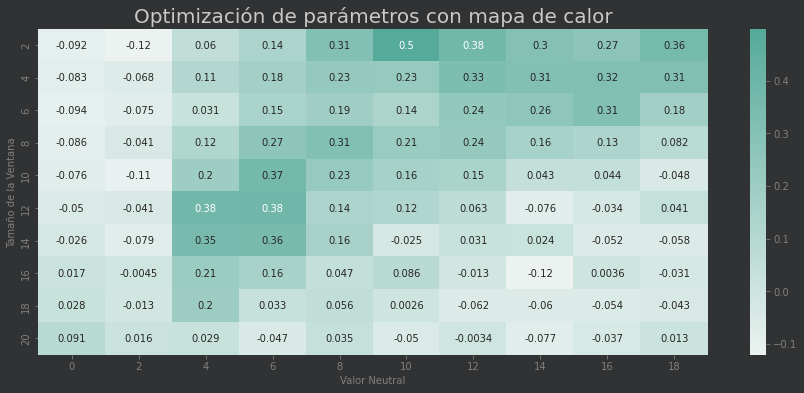

In [7]:
# Import the data
f = yf.download("GOOG")

# We set lists for the possible values of neutral and window
neutral_values = [i*2 for i in range(10)]
window_values = [i*2 for i in range(1,11)]


# We set matrix with only zeros 
grid = np.zeros([len(neutral_values), len(window_values)])

# We will in parmters calculate the return of the strategy for each combinaison
for i in range(len(neutral_values)):
  for j in range(len(window_values)):

    # Compute return strategy
    return_rsi = RSI(f, neutral_values[i], window_values[j])

    # Compute annualized sortino
    grid[i][j] = np.sqrt(252) * return_rsi.mean() / (return_rsi[return_rsi<0].std()+0.00001)

# Adapt the size
plt.figure(figsize=(15,6))

# Palette for color
pal = sns.color_palette("light:#5A9", as_cmap=True)

# Plot the heatmap
sns.heatmap(grid, annot=True, xticklabels=neutral_values, yticklabels=window_values, cmap = pal)

# Put a title
plt.title("Optimización de parámetros con mapa de calor", size=20)

# Put a xlabel
plt.xlabel("Valor Neutral")

# Put a xlabel
plt.ylabel("Tamaño de la Ventana")

# Show the graph
plt.show()

In [8]:
# We create just a function for the previous code
def grid_parameters(f):

  # We set lists for the possible values of neutral and window
  neutral_values = [i*2 for i in range(10)]
  window_values = [i*2 for i in range(1,11)]

  # We set matrix with only zeros 
  grid = np.zeros([len(neutral_values), len(window_values)])

  # We wil calculate the return of the strategy for each combinaison
  for i in range(len(neutral_values)):
    for j in range(len(window_values)):

      # Compute return strategy
      return_rsi = RSI(f, neutral_values[i], window_values[j])

      # Compute annualized sortino
      grid[i][j] = np.sqrt(252) * return_rsi.mean() / return_rsi[return_rsi<0].std()

  return grid

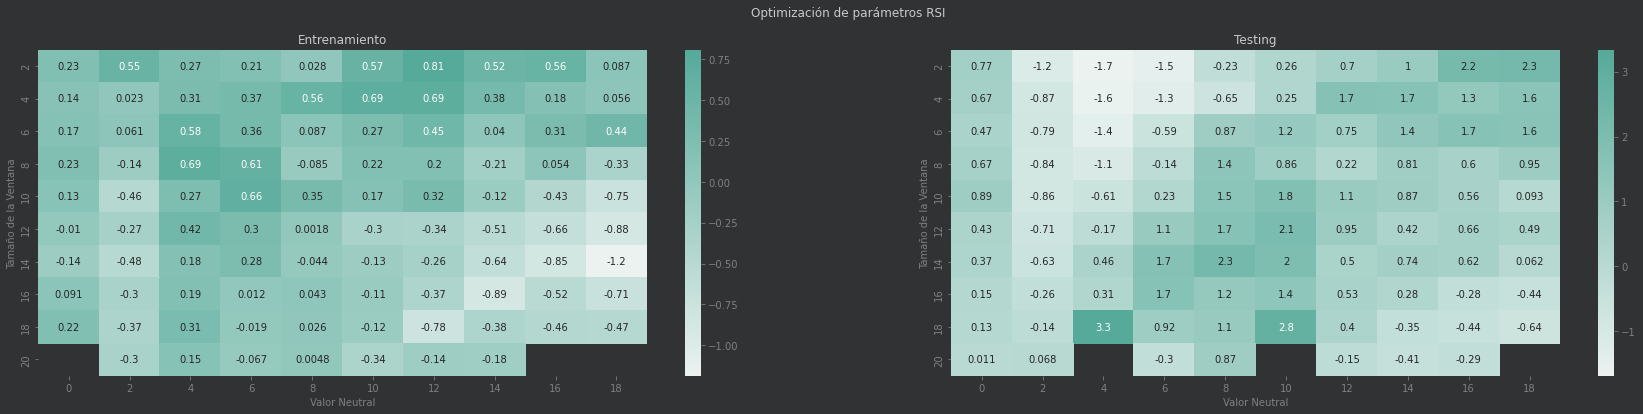

In [9]:
# We set lists for the possible values of neutral and window
neutral_values = [i*2 for i in range(10)]
window_values = [i*2 for i in range(1,11)]

# Set some datasets
start_train, end_train = "2017-01-01", "2019-01-01"
start_test, end_test = "2019-01-01", "2020-01-01"
start_valid, end_valid = "2020-01-01", "2021-01-01"

# Create the grids
grid_train = grid_parameters(f.loc[start_train:end_train])
grid_test = grid_parameters(f.loc[start_test:end_test])

# Create a subplots
fig, (train,test) = plt.subplots(1,2,figsize=(30,6))

# Put a sup title
fig.suptitle("Optimización de parámetros RSI")

# Change the color
pal = sns.color_palette("light:#5A9", as_cmap=True)

# Train
# Put train heatmap
sns.heatmap(grid_train, annot=True, ax=train, xticklabels=neutral_values, yticklabels=window_values, cmap = pal)

# Set a title
train.set_title("Entrenamiento")

# Set a xlabel
train.set_xlabel("Valor Neutral")

# Set a ylabel
train.set_ylabel("Tamaño de la Ventana")


# Test
# Put test heatmap
sns.heatmap(grid_test, annot=True, ax=test, xticklabels=neutral_values, yticklabels=window_values, cmap= pal)

# Set a title
test.set_title("Testing")

# Set a xlabel
test.set_xlabel("Valor Neutral")

# Set a ylabel
test.set_ylabel("Tamaño de la Ventana")   


# Show the graph
plt.show()

[*********************100%***********************]  1 of 1 completed


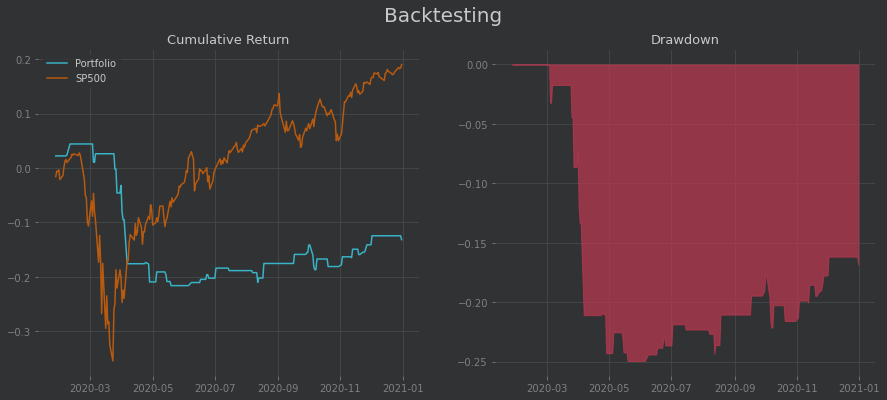

Sortino: -0.454
Beta: -0.035
Alpha: -0.145
MaxDrawdown: 24.944 %


In [10]:
# BackTest
BackTest(RSI(f.loc[start_valid:end_valid],10,3))

# Sección 2: Selección de parámetros basado en Estadística

In [38]:
# Selección de parámetros basado en Estadística

# Definimos la lista de los valores posibles de neutral y de la ventana
neutral_values = [i*2 for i in range(10)]
window_values = [i*2 for i in range(1,11)]

# Establecemos las fronteras de cada conjunto
start_train, end_train = "2017-01-01", "2019-01-01"
start_test, end_test = "2019-01-01", "2020-01-01"
start_valid, end_valid = "2020-01-01", "2021-01-01"

# Inicializamos la lista
resume = []

# Bucle para añadir los valores a la lista
for i in range(len(neutral_values)):
    for j in range(len(window_values)):

      # Calculamos el retorno
      return_train = RSI(f.loc[start_train:end_train], neutral_values[i], window_values[j])
      return_test = RSI(f.loc[start_test:end_test], neutral_values[i], window_values[j])

      # Calculamos el ratio de Sortino
      sortino_train = np.sqrt(252) * return_train.mean() / return_train[return_train<0].std()
      sortino_test = np.sqrt(252) * return_test.mean() / return_test[return_test<0].std()

      # Lo guardamos en una lista de listas para crear un data frame
      values = [neutral_values[i], window_values[j], sortino_train, sortino_test]
      resume.append(values)

resume = pd.DataFrame(resume, columns=["Neutral", "Window", "Sortino Train", "Sortino Test"])

In [39]:
resume

,Neutral,Window,Sortino Train,Sortino Test
0,0,2,0.204706,0.778629
1,0,4,0.453732,-0.787545
2,0,6,0.187543,-1.256893
3,0,8,0.078549,-1.045791
4,0,10,-0.105137,1.425558
...,...,...,...,...
95,18,12,-0.341991,NaN
96,18,14,-0.144054,-0.153922
97,18,16,-0.181135,-0.413136
98,18,18,NaN,-0.288646


In [40]:
# Ordenamos por Sortino
ordered_resume = resume.sort_values(by="Sortino Train", ascending=False)


best = ordered_resume.iloc[0:1,:]

# Calculamos el ratio sortino
Strain = best["Sortino Train"].values[0]
Stest = best["Sortino Test"].values[0]
# Initialize the i
i = 0

for i in range(len(resume)):
    # Elegimos el mejor
    best = ordered_resume.iloc[0+i:1+i,:]

    # Calculamos el ratio sortino
    Strain = best["Sortino Train"].values[0]
    Stest = best["Sortino Test"].values[0]

    # Seleccionamos el mejor valor neutro y la mejor ventana
    best_neutral = best["Neutral"].values[0]
    best_window = best["Window"].values[0]

    # Si ambos ratios de Sortino son lo bastante altos, nos quedamos con esta selección
    if Stest>0.5 and Strain>0.5:
      break

    # Si no hay valor óptimo, los devolvemos a cero
    else:
      best_neutral = 0
      best_window = 0
      Strain = 0
      Stest = 0



In [41]:
# Plot the values
best_neutral, best_window, Strain, Stest

(8, 8, 0.655298207597889, 0.7140675166690964)

[*********************100%***********************]  1 of 1 completed


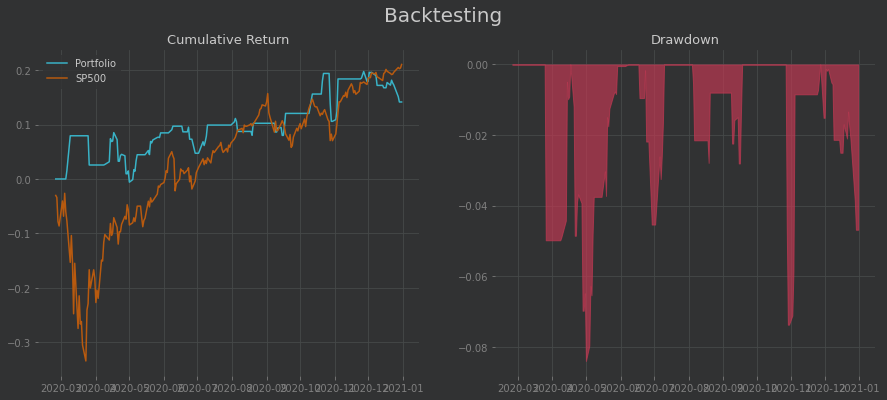

Sortino: 0.719
Beta: 0.006
Alpha: 0.163
MaxDrawdown: 8.398 %


In [44]:
# BackTest
BackTest(RSI(f.loc[start_valid:end_valid],8,8))

# Sección 3: Crear una función para utilizar en las próximas secciones

In [19]:
def opt(f):
  # Establecemos listas para los posibles valores de neutro y ventana
  neutral_values = [i*2 for i in range(10)]
  window_values = [i*2 for i in range(1,11)]

  # Definimos los valores límite de cada dataset
  start_train, end_train = "2017-01-01", "2019-01-01"
  start_test, end_test = "2019-01-01", "2020-01-01"
  start_valid, end_valid = "2020-01-01", "2021-01-01"


  # Inicializamos la lista
  resume = []

  # Bucle para añadir los valores de la lista
  for i in range(len(neutral_values)):
      for j in range(len(window_values)):
        # Calculamos los retornos
        return_train = RSI(f.loc[start_train:end_train], neutral_values[i], window_values[j])
        return_test = RSI(f.loc[start_test:end_test], neutral_values[i], window_values[j])

        # Calculamos el Ratio de Sortino
        sortino_train = np.sqrt(252) * return_train.mean() / return_train[return_train<0].std()
        sortino_test = np.sqrt(252) * return_test.mean() / return_test[return_test<0].std()

        # Creamos una lista de listas para construir el dataframe
        values = [neutral_values[i], window_values[j], sortino_train, sortino_test]
        resume.append(values)

  resume = pd.DataFrame(resume, columns=["Neutral", "Window", "Sortino Train", "Sortino Test"])

  # Ordenamos por Ratio de sortino
  ordered_resume = resume.sort_values(by="Sortino Train", ascending=False)



  for i in range(len(resume)):
    # Nos quedamos con el mejor
    best = ordered_resume.iloc[0+i:1+i,:]

    # Calculamos el Ratio de Sortino
    Strain = best["Sortino Train"].values[0]
    Stest = best["Sortino Test"].values[0]

    # Toma el mejor neutro y la mejor ventana
    best_neutral = best["Neutral"].values[0]
    best_window = best["Window"].values[0]

    # Si el Sortino del tren y la prueba son buenos detenemos el bucle
    if Stest>0.5 and Strain>0.5:
      break

    # Si no hay valores suficientemente buenos se pone 0 en todos los valores
    else:
      best_neutral = 0
      best_window = 0
      Strain = 0
      Stest = 0
  return [best_neutral, best_window, Strain, Stest]

In [46]:
# Find optimal parameters
m = yf.download("TSLA")
opt(m.dropna())

[*********************100%***********************]  1 of 1 completed


[10, 4, 0.5754813483109821, 0.6663824233493243]

[*********************100%***********************]  1 of 1 completed


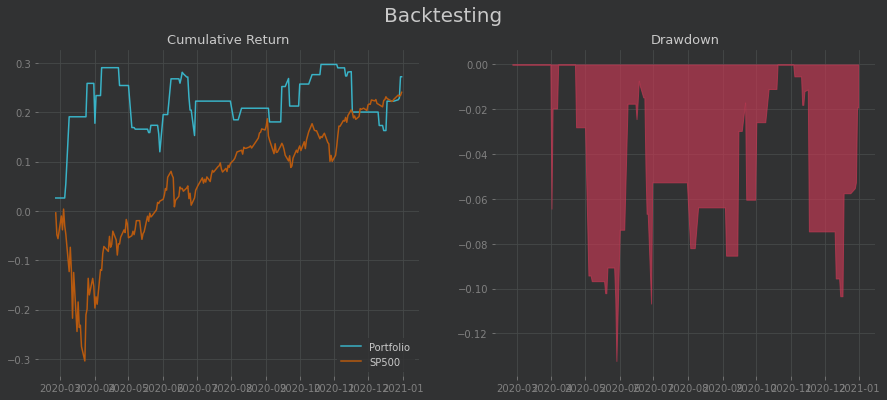

Sortino: 0.757
Beta: -0.034
Alpha: 0.329
MaxDrawdown: 13.226 %


In [47]:
# BackTest
BackTest(RSI(m.loc[start_valid:end_valid], 10, 4))